In [1]:
# Dataset

In [2]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-11-02 13:19:28--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-02 13:19:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.01s   

2024-11-02 13:19:29 (29.4 MB/s) - ‘jamb_exam_result

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('jamb_exam_results.csv')

In [5]:
# Preparing the dataset

In [6]:
## Make the names lowercase

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [8]:
## Remove the student_id column

In [9]:
del df['student_id']

In [10]:
## Fill missing values with zeros

In [11]:
df.isna().sum().any().item()

True

In [12]:
df = df.fillna(0)

In [13]:
df.isna().sum().any().item()

False

In [14]:
## Do train/validation/test split with 60%/20%/20% distribution.
## Use the train_test_split function and set the random_state parameter to 1.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values


del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [17]:
## Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [18]:
from sklearn.feature_extraction import DictVectorizer

In [19]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.fit_transform(df_val.to_dict(orient='records'))
X_test = dv.fit_transform(df_test.to_dict(orient='records'))

In [20]:
# Question 1

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [22]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [23]:
# Question 2

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [25]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred).item()

42.13724207871227

In [26]:
# Question 3

In [27]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred).item()
    
    scores.append((n, round(rmse, 3), scores[-1][1] > rmse if len(scores) > 0 else True))

In [28]:
print("n_estimators\trmse\t\tis_smaller")
for score in scores:
    print(score[0], ":\t\t", score[1], "\t", score[2])

n_estimators	rmse		is_smaller
10 :		 42.137 	 True
20 :		 41.461 	 True
30 :		 41.106 	 True
40 :		 40.917 	 True
50 :		 40.852 	 True
60 :		 40.784 	 True
70 :		 40.677 	 True
80 :		 40.539 	 True
90 :		 40.504 	 True
100 :		 40.517 	 False
110 :		 40.593 	 False
120 :		 40.625 	 False
130 :		 40.651 	 False
140 :		 40.595 	 True
150 :		 40.597 	 False
160 :		 40.604 	 False
170 :		 40.628 	 False
180 :		 40.641 	 False
190 :		 40.631 	 True
200 :		 40.601 	 True


In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

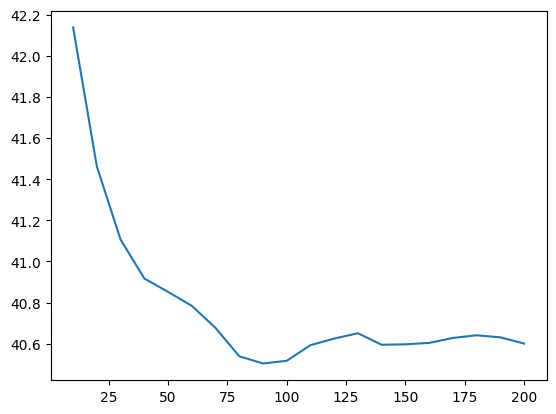

In [30]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse', "is_smaller"])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [31]:
# Question 4

In [32]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred).item()

        scores.append((d, n, rmse))

In [33]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

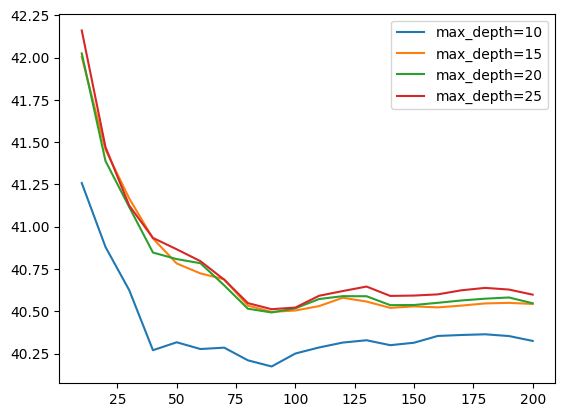

In [34]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [35]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
df_scores_pivot.mean()

      max_depth
rmse  10           40.392498
      15           40.735282
      20           40.739734
      25           40.787866
dtype: float64

In [36]:
# Question 5

In [37]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
feature_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names_out())
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances

study_hours_per_week                0.248354
attendance_rate                     0.149729
distance_to_school                  0.136486
teacher_quality                     0.082682
age                                 0.069311
assignments_completed               0.031517
socioeconomic_status=High           0.025714
parent_involvement=High             0.022919
it_knowledge=High                   0.017719
parent_education_level=Secondary    0.016957
parent_education_level=Primary      0.015450
parent_education_level=Tertiary     0.014489
extra_tutorials=No                  0.013459
parent_involvement=Low              0.013358
it_knowledge=Low                    0.012404
access_to_learning_materials=No     0.012325
parent_involvement=Medium           0.011492
socioeconomic_status=Low            0.010708
socioeconomic_status=Medium         0.010563
gender=Male                         0.010383
access_to_learning_materials=Yes    0.010262
school_location=Rural               0.009559
gender=Fem

In [39]:
# Question 6

In [40]:
import xgboost as xgb

In [41]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [42]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [43]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=100,
                  verbose_eval=100,
                  evals=watchlist)

[0]	train-rmse:42.69384	val-rmse:44.89114
[99]	train-rmse:11.39140	val-rmse:43.41882


In [44]:
root_mean_squared_error(y_val, model.predict(dval)).item()

43.418817345871766

In [45]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=100,
                  verbose_eval=100,
                  evals=watchlist)

[0]	train-rmse:45.49999	val-rmse:47.00533
[99]	train-rmse:23.59704	val-rmse:41.05034


In [46]:
root_mean_squared_error(y_val, model.predict(dval)).item()

41.05034017683498